# Setup + downloading data



In [1]:
import os
import pandas as pd
from qiime2 import Visualization
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_dir = "project_data"
os.makedirs(data_dir, exist_ok=True)
data_dir

'project_data'

In [3]:
%%bash -s "$data_dir"
set -e
mkdir -p "$1"
cd "$1"

if [ ! -f ITS1_sequences.qza ]; then
    echo "Downloading ITS1_sequences.qza …"
    wget -q -O ITS1_sequences.qza \
        "https://polybox.ethz.ch/index.php/s/uV06vmm96ZzB5eM/download"
else
    echo "ITS1_sequences.qza already exists – skipping download."
fi

if [ ! -f sample_metadata.tsv ]; then
    echo "Downloading sample_metadata.tsv …"
    wget -q -O sample_metadata.tsv \
        "https://polybox.ethz.ch/index.php/s/CA76kKFC9FApqpR/download"
else
    echo "sample_metadata.tsv already exists – skipping download."
fi

ls -lh

ITS1_sequences.qza already exists – skipping download.
sample_metadata.tsv already exists – skipping download.
total 683M
-rw-r--r-- 1 jovyan jovyan 680M Sep 27 19:51 ITS1_sequences.qza
-rw-r--r-- 1 jovyan jovyan  83K Oct  8 11:04 dada2_rep_set.qza
-rw-r--r-- 1 jovyan jovyan 326K Oct  8 11:11 dada2_rep_set.qzv
-rw-r--r-- 1 jovyan jovyan  54K Oct  8 11:04 dada2_stats.qza
-rw-r--r-- 1 jovyan jovyan 1.3M Oct  8 11:10 dada2_stats.qzv
-rw-r--r-- 1 jovyan jovyan  92K Oct  8 11:04 dada2_table.qza
-rw-r--r-- 1 jovyan jovyan 486K Oct  8 11:11 dada2_table.qzv
-rw-r--r-- 1 jovyan jovyan 333K Oct  8 10:55 demux_seqs.qzv
-rw-r--r-- 1 jovyan jovyan  19K Sep 27 20:12 sample_metadata.tsv
drwxr-xr-x 2 jovyan jovyan 4.0K Oct 12 03:51 unite_train


# Meta data analysis

In [18]:
metadata_df = pd.read_csv(f'{data_dir}/sample_metadata.tsv', sep='\t', index_col=0)
metadata_df.sample(5)

,country_sample,state_sample,latitude_sample,longitude_sample,sex_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,diet_type_sample,ibd_sample,gluten_sample
ID,,,,,,,,,,,,
ERR5327266,USA,VA,38.9,-77.1,female,28.0,175.0,61.0,19.94,Omnivore,I do not have this condition,I do not eat gluten because it makes me feel bad
ERR5327615,United Kingdom,Not provided,51.8,-1.3,female,53.0,176.0,64.0,20.66,Omnivore,I do not have this condition,No
ERR5327471,United Kingdom,Not provided,50.5,-3.8,male,77.0,177.0,71.0,22.67,Vegetarian,I do not have this condition,Not provided
ERR5327344,Australia,QLD,-27.6,152.9,female,46.0,152.0,66.0,28.42,Omnivore,I do not have this condition,No
ERR5327493,United Kingdom,Not provided,51.5,-0.6,male,46.0,175.0,68.0,22.15,Omnivore,I do not have this condition,No


In [19]:
metadata_df.describe()

,country_sample,state_sample,latitude_sample,longitude_sample,sex_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,diet_type_sample,ibd_sample,gluten_sample
count,150,150,150,150,150,150,150,150,150,150,150,150
unique,8,30,86,81,4,64,47,70,135,6,4,5
top,United Kingdom,Not provided,51.5,145.0,male,55.0,180.0,63.0,Not provided,Omnivore,I do not have this condition,No
freq,54,58,14,5,79,6,15,8,3,118,130,113


<Axes: title={'center': 'Sex ratio'}, xlabel='sex_sample'>

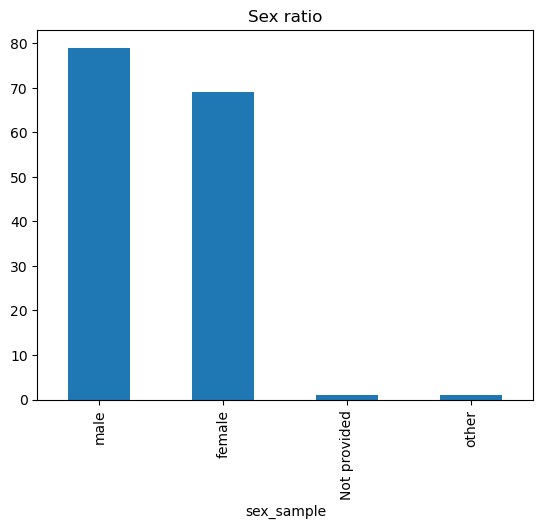

In [20]:
metadata_df['sex_sample'].value_counts().plot(kind='bar', title='Sex ratio')

In [23]:
# coerce several columns to numeric
num_cols = ['age_years_sample','height_cm_sample','weight_kg_sample',
            'bmi_sample','latitude_sample','longitude_sample']
metadata_df[num_cols] = (metadata_df[num_cols]
                         .replace('Not provided', pd.NA)
                         .apply(pd.to_numeric, errors='coerce'))

In [24]:
(mean_bmi_by_country :=
    metadata_df.groupby('country_sample')['bmi_sample']
               .mean()
               .sort_values(ascending=False))

mean_bmi_by_country

country_sample
Not provided      28.110000
USA               24.672500
United Kingdom    24.519444
New Zealand       24.363333
Australia         23.197619
Germany           22.630000
Isle of Man       21.970000
Sweden            19.140000
Name: bmi_sample, dtype: float64

# Sequence import & summary

In [10]:
seqs_qza = f'{data_dir}/ITS1_sequences.qza'

In [11]:
!qiime tools peek {seqs_qza}

UUID:        3638611d-1767-413b-9390-70ee3d78e4ff
Type:        SampleData[SequencesWithQuality]
Data format: SingleLanePerSampleSingleEndFastqDirFmt


In [12]:
!qiime demux summarize \
  --i-data {seqs_qza} \
  --o-visualization {data_dir}/demux_seqs.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: project_data/demux_seqs.qzv


<visualization: Visualization uuid: 97109369-2c96-4a3e-a593-4002f62d973c>

In [ ]:
Visualization.load(f"{data_dir}/demux_seqs.qzv")

# Feature table construction

In [15]:
! qiime dada2 denoise-single help

Usage: qiime dada2 denoise-single [OPTIONS]

  This method denoises single-end sequences, dereplicates them, and filters
  chimeras.

Inputs:
  --i-demultiplexed-seqs ARTIFACT SampleData[SequencesWithQuality |
    PairedEndSequencesWithQuality]
                          The single-end demultiplexed sequences to be
                          denoised.                                 [required]
Parameters:
  --p-trunc-len INTEGER   Position at which sequences should be truncated due
                          to decrease in quality. This truncates the 3' end of
                          the of the input sequences, which will be the bases
                          that were sequenced in the last cycles. Reads that
                          are shorter than this value will be discarded. If 0
                          is provided, no truncation or length filtering will
                          be performed                              [required]
  --p-trim-left INTEGER   Position at which se

In [19]:
! qiime dada2 denoise-single \
  --i-demultiplexed-seqs project_data/ITS1_sequences.qza \
  --p-trunc-len 130 \
  --p-n-threads 3 \
  --p-max-ee 4 \
  --p-min-fold-parent-over-abundance 4 \
  --o-table project_data/dada2_table.qza \
  --o-representative-sequences project_data/dada2_rep_set.qza \
  --o-denoising-stats project_data/dada2_stats.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: project_data/dada2_table.qza
Saved FeatureData[Sequence] to: project_data/dada2_rep_set.qza
Saved SampleData[DADA2Stats] to: project_data/dada2_stats.qza


### Denoising - Amplicon Sequence Variants

In [19]:
! qiime metadata tabulate \
  --m-input-file project_data/dada2_stats.qza \
  --o-visualization project_data/dada2_stats.qzv

! qiime feature-table tabulate-seqs \
  --i-data project_data/dada2_rep_set.qza \
  --o-visualization project_data/dada2_rep_set.qzv

! qiime feature-table summarize \
  --i-table project_data/dada2_table.qza \
  --m-sample-metadata-file project_data/sample_metadata.tsv \
  --o-visualization project_data/dada2_table.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: project_data/dada2_stats.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: project_data/dada2_rep_set.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 

In [17]:
Visualization.load("project_data/dada2_table.qzv")

<visualization: Visualization uuid: 0139812f-cc6b-4e2a-838a-e46aca2b997b>

In [22]:
Visualization.load("project_data/dada2_stats.qzv")

<visualization: Visualization uuid: 9bfbfd4e-21c0-4d7b-a8a0-f19c29c7d483>

# Taxonomy

### Reference Database Construction

In [4]:
mkdir -p project_data/unite_train

In [5]:
# Download UNITE data
! qiime rescript get-unite-data \
  --p-version 2025-02-19 \
  --o-sequences project_data/unite_train/unite_raw_seqs.qza \
  --o-taxonomy project_data/unite_train/unite_raw_tax.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Taxonomy] to: project_data/unite_train/unite_raw_tax.qza
Saved FeatureData[Sequence] to: project_data/unite_train/unite_raw_seqs.qza


### Database Curation

In [7]:
# remove placeholders
! qiime taxa filter-seqs \
  --i-sequences project_data/unite_train/unite_raw_seqs.qza \
  --i-taxonomy project_data/unite_train/unite_raw_tax.qza \
  --p-exclude Fungi_sp,mycota_sp,mycetes_sp \
  --o-filtered-sequences project_data/unite_train/sequences-filtered.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: project_data/unite_train/sequences-filtered.qza


In [8]:
# strip SH codes in taxonomy
! qiime rescript edit-taxonomy \
  --i-taxonomy project_data/unite_train/unite_raw_tax.qza \
  --p-search-strings 'SH;__' \
  --p-replacement-strings '' \
  --p-use-regex \
  --o-edited-taxonomy project_data/unite_train/taxonomy-no-SH.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Taxonomy] to: project_data/unite_train/taxonomy-no-SH.qza


In [9]:
# extract ITS1
! qiime feature-classifier extract-reads \
  --i-sequences project_data/unite_train/sequences-filtered.qza \
  --p-f-primer 'CTTGGTCATTTAGAGGAAGTAA' \
  --p-r-primer 'GCTGCGTTCTTCATCGATGC' \
  --p-trunc-len 0 \
  --o-reads project_data/unite_train/sequences-eukaryote-ITS1.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: project_data/unite_train/sequences-eukaryote-ITS1.qza


In [10]:
# dereplicate
! qiime rescript dereplicate \
  --i-sequences project_data/unite_train/sequences-eukaryote-ITS1.qza \
  --i-taxa project_data/unite_train/taxonomy-no-SH.qza \
  --p-perc-identity 0.99 \
  --o-dereplicated-sequences project_data/unite_train/derep-seqs-ITS1.qza \
  --o-dereplicated-taxa project_data/unite_train/derep-tax-ITS1.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Sequence] to: project_data/unite_train/derep-seqs-ITS1.qza
Saved FeatureData[Taxonomy] to: project_data/unite_train/derep-tax-ITS1.qza


### Train Classifier

In [11]:
# train classifier
! qiime feature-classifier fit-classifier-naive-bayes \
  --i-reference-reads project_data/unite_train/derep-seqs-ITS1.qza \
  --i-reference-taxonomy project_data/unite_train/derep-tax-ITS1.qza \
  --o-classifier project_data/unite_train/classifier-ITS1-eukaryote.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved TaxonomicClassifier to: project_data/unite_train/classifier-ITS1-eukaryote.qza


In [12]:
# assign taxonomy to your ASVs (DADA2 output)
! qiime feature-classifier classify-sklearn \
  --i-classifier project_data/unite_train/classifier-ITS1-eukaryote.qza \
  --i-reads project_data/dada2_rep_set.qza \
  --o-classification project_data/taxonomy.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureData[Taxonomy] to: project_data/taxonomy.qza


### Visualisation

In [13]:
# inspect taxonomy
! qiime metadata tabulate \
  --m-input-file project_data/taxonomy.qza \
  --o-visualization project_data/taxonomy.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: project_data/taxonomy.qzv


In [14]:
Visualization.load(f"{data_dir}/taxonomy.qzv")

<visualization: Visualization uuid: 93a65ff1-21a6-43d9-a980-62a62a645c49>

In [15]:
# taxa barplot
! qiime taxa barplot \
  --i-table project_data/dada2_table.qza \
  --i-taxonomy project_data/taxonomy.qza \
  --m-metadata-file project_data/sample_metadata.tsv \
  --o-visualization project_data/taxa-bar-plots.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: project_data/taxa-bar-plots.qzv


In [16]:
Visualization.load(f"{data_dir}/taxa-bar-plots.qzv")

<visualization: Visualization uuid: 60def598-ec44-46e2-8200-cdcdd9d75708>

# Alpha rarefaction

In [21]:
! qiime diversity alpha-rarefaction \
    --i-table project_data/dada2_table.qza \
    --p-max-depth 10000 \
    --m-metadata-file project_data/sample_metadata.tsv \
    --o-visualization project_data/alpha-rarefaction.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: project_data/alpha-rarefaction.qzv


In [22]:
Visualization.load(f"{data_dir}/alpha-rarefaction.qzv")

<visualization: Visualization uuid: e61a0130-4f57-4ad7-8534-6976a5c79d8d>

In [23]:
! qiime diversity core-metrics \
  --i-table project_data/dada2_table.qza \
  --p-sampling-depth 1500 \
  --m-metadata-file project_data/sample_metadata.tsv \
  --output-dir project_data/core-metrics

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: project_data/core-metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: project_data/core-metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: project_data/core-metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: project_data/core-metrics/evenness_vector.qza
Saved DistanceMatrix to: project_data/core-metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: project_data/core-metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: project_data/core-metrics/jaccard_pcoa_results.qza
Saved PCoAResults to: project_data/core-metrics/bray_curtis_pcoa_results.qza
Saved Visualization to: 

### Statistical Testing

In [24]:
! qiime diversity alpha-group-significance \
  --i-alpha-diversity project_data/core-metrics/shannon_vector.qza \
  --m-metadata-file project_data/sample_metadata.tsv \
  --o-visualization project_data/core-metrics/shannon-group-significance.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: project_data/core-metrics/shannon-group-significance.qzv


In [26]:
Visualization.load(f"{data_dir}/core-metrics/shannon-group-significance.qzv")

<visualization: Visualization uuid: b215ca06-9c06-4e19-b56d-61c759b68c1e>

In [27]:
! qiime diversity alpha-correlation \
  --i-alpha-diversity project_data/core-metrics/shannon_vector.qza \
  --m-metadata-file project_data/sample_metadata.tsv \
  --o-visualization project_data/core-metrics/shannon-group-significance-numeric.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Plugin error from diversity:

  Metadata contains only non-numeric or empty columns. This visualizer requires at least one numeric metadata column to execute.

Debug info has been saved to /tmp/qiime2-q2cli-err-3pwwxucq.log


In [ ]:
Visualization.load(f"{data_dir}/core-metrics/shannon-group-significance-numeric.qzv")